In [1]:
import pandas as pd
import numpy as np

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
# from sklearn.

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

### Removing Null values

In [4]:
train_data=train_data.dropna(how='any')

### Adding Date Columns

In [5]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)

In [6]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'Day', 'Hour'],
      dtype='object')

### Dividing data into train and validation

In [7]:
X, y=train_data.drop('Rating', axis=1), train_data['Rating']
X_test=test_data

In [8]:
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=29)

### Pipeline

In [165]:
col_transform=ColumnTransformer([('scaler', MinMaxScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'BestScore']),
                                #  ('day_encode', OneHotEncoder(), ['Day']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', CountVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])
weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', LogisticRegression(class_weight=weights, penalty='l2', #penalty='elasticnet', 
                                               C=0.015, multi_class='multinomial', solver='lbfgs', #solver='saga', l1_ratio=0,
                                               max_iter=200, n_jobs=-1))])

In [166]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  CountVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000017D8F74C4C0>)),
                ('clsf',
                 LogisticRegression(C=0.015,
                                    class_weight={0: 4, 1: 8, 2: 12, 3: 6,
                                                  4: 3.5, 5: 1.8},
                                    max_iter=200, multi_class='multinomial',
                                    n_jobs=-1))])

### Train Report

In [167]:
train_predict=pipeline.predict(X_train)

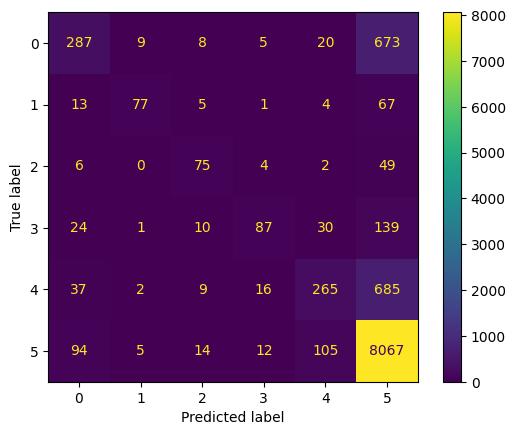

In [168]:
ConfusionMatrixDisplay.from_predictions(y_train, train_predict, display_labels=pipeline.classes_);

In [169]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.62      0.29      0.39      1002
           1       0.82      0.46      0.59       167
           2       0.62      0.55      0.58       136
           3       0.70      0.30      0.42       291
           4       0.62      0.26      0.37      1014
           5       0.83      0.97      0.90      8297

    accuracy                           0.81     10907
   macro avg       0.70      0.47      0.54     10907
weighted avg       0.79      0.81      0.78     10907



In [170]:
accuracy_score(y_train, train_predict)

0.8121389933070505

### Test Report

In [171]:
valid_predict=pipeline.predict(X_valid)

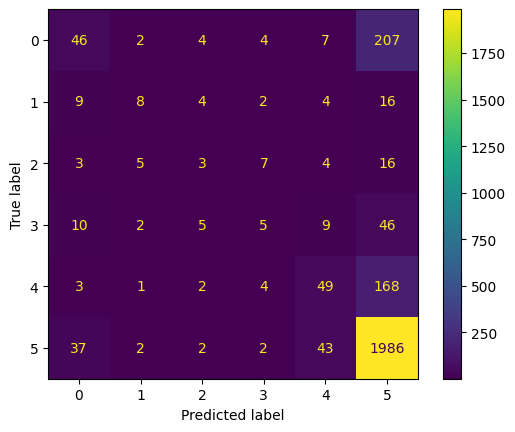

In [174]:
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);

In [175]:
print(classification_report(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.43      0.17      0.24       270
           1       0.40      0.19      0.25        43
           2       0.15      0.08      0.10        38
           3       0.21      0.06      0.10        77
           4       0.42      0.22      0.29       227
           5       0.81      0.96      0.88      2072

    accuracy                           0.77      2727
   macro avg       0.40      0.28      0.31      2727
weighted avg       0.71      0.77      0.73      2727



In [176]:
accuracy_score(y_valid, valid_predict)

0.768976897689769

### Training on whole dataset

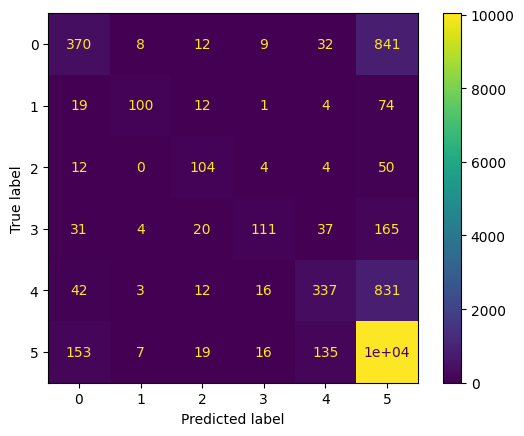

In [142]:
pipeline.fit(X, y)
whole_predict=pipeline.predict(X)
ConfusionMatrixDisplay.from_predictions(y, whole_predict, display_labels=pipeline.classes_);

In [143]:
print(classification_report(y, whole_predict))

              precision    recall  f1-score   support

           0       0.59      0.29      0.39      1272
           1       0.82      0.48      0.60       210
           2       0.58      0.60      0.59       174
           3       0.71      0.30      0.42       368
           4       0.61      0.27      0.38      1241
           5       0.84      0.97      0.90     10369

    accuracy                           0.81     13634
   macro avg       0.69      0.48      0.55     13634
weighted avg       0.79      0.81      0.78     13634



In [144]:
accuracy_score(y, whole_predict)

0.8112806219744756

In [338]:
test_predict=pipeline.predict(X_test)